In [89]:
import matplotlib.pyplot as plt
import dill
import sympy
from tqdm import tqdm
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve

### Load precomputed integrals

In [90]:
lagrange_linear_poisson_matrix = dill.load(
    open("../../calculations/lagrange_linear_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../../calculations/lagrange_linear_poisson_right_values", "rb")
)
consistency_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_consistency", "rb")
)
consistency_boundary_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_consistency_boundary", "rb")
)
symmetricity_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_symmetricity", "rb")
)
symmetricity_boundary_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_symmetricity_boundary", "rb")
)
penalty_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_penalty", "rb")
)
penalty_boundary_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_penalty_boundary", "rb")
)

### Initialize the domain

In [91]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt


gmsh.initialize()
gmsh.model.add("tri_mesh")

ms = 0.25
# Define points
point_1 = gmsh.model.geo.addPoint(0, 0, 0, ms)
point_2 = gmsh.model.geo.addPoint(1, 0, 0, ms)
point_3 = gmsh.model.geo.addPoint(0, 1, 0, ms)
point_4 = gmsh.model.geo.addPoint(-1, 0, 0, ms)
point_5 = gmsh.model.geo.addPoint(0, -1, 0, ms)

# Define circles
arc_1 = gmsh.model.geo.addCircleArc(point_2, point_1, point_3)
arc_2 = gmsh.model.geo.addCircleArc(point_3, point_1, point_4)
arc_3 = gmsh.model.geo.addCircleArc(point_4, point_1, point_5)
arc_4 = gmsh.model.geo.addCircleArc(point_5, point_1, point_2)

# Define line loop
circle = gmsh.model.geo.addCurveLoop([arc_1, arc_2, arc_3, arc_4])

# Define plane surface
plane = gmsh.model.geo.addPlaneSurface([circle])

gmsh.model.geo.synchronize()

ms = 25
gmsh.model.mesh.setTransfiniteCurve(arc_1, ms)
gmsh.model.mesh.setTransfiniteCurve(arc_2, ms)
gmsh.model.mesh.setTransfiniteCurve(arc_3, ms)
gmsh.model.mesh.setTransfiniteCurve(arc_4, ms)
gmsh.model.mesh.setTransfiniteSurface(plane)

physical_group_curves_tag = gmsh.model.addPhysicalGroup(1, [arc_1, arc_2, arc_3, arc_4], name="Boundary curves")
physical_group_surface_tag = gmsh.model.addPhysicalGroup(2, [plane], name="Surface")

gmsh.option.setNumber(name="Mesh.Smoothing", value=20)
gmsh.model.mesh.generate(2)
# gmsh.fltk.run()

# Triangles

In [92]:
boundary_node_tags, boundary_node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, physical_group_curves_tag)
surface_node_tags, points = gmsh.model.mesh.getNodesForPhysicalGroup(2, physical_group_surface_tag)
points = points.reshape(-1, 3)[:, :-1]
boundary_node_tags = boundary_node_tags - 1

In [93]:
element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements()
triangles = [nodes for elem_type, nodes in zip(element_types, element_node_tags) if elem_type == 2][0]
triangles = triangles.reshape(-1, 3)
triangles = triangles - 1

def orient_batch(arg):
    indices = np.argsort(arg, axis=-1)
    res = np.take_along_axis(arg, indices, axis=-1)

    return res

triangles = orient_batch(triangles)

In [94]:
vertex_marker_is_boundary = np.zeros(surface_node_tags.shape[0])
vertex_marker_is_boundary[boundary_node_tags] = 1

In [95]:
all_edges = triangles[:, [[1, 2], [0, 2], [0, 1]]].reshape(-1, 2)
all_edges = np.sort(all_edges, axis=-1)
all_edges, _, indices, counts = np.unique(all_edges, axis=0, return_counts=True, return_inverse=True, return_index=True)
edge_marker_is_boundary = (counts == 1).astype(int)[:, None]

## Triangles to edges

In [96]:
triangles_to_edges = indices.reshape(-1, 3)

## Vertices to edges

In [97]:
vertices_to_edges = []

for test_idx in range(points.shape[0]):
    vertices_to_edges.append([])

for e_idx, edge in enumerate(all_edges):
    for pidx in edge:
        vertices_to_edges[pidx].append(e_idx)

## Edges to edges

In [98]:
edges_to_edges = []

for test_idx in range(all_edges.shape[0]):
    edges_to_edges.append([])

for e_idx, edge in enumerate(all_edges):
    
    edges_to_edges[e_idx].extend(vertices_to_edges[edge[0]])
    edges_to_edges[e_idx].extend(vertices_to_edges[edge[1]])
    edges_to_edges[e_idx] = list(set(edges_to_edges[e_idx]))
    edges_to_edges[e_idx].remove(e_idx)

## Edges to triangles

In [99]:
edges_to_triangles = []

for test_idx in range(all_edges.shape[0]):
    edges_to_triangles.append([])

for t_idx, edge in enumerate(triangles_to_edges):
    
    for e_idx in edge:
        edges_to_triangles[e_idx].append(t_idx)

for t_idx, v in enumerate(edges_to_triangles):
    if len(v) == 1:
        edges_to_triangles[t_idx].append(-1)

edges_to_triangles = np.array(edges_to_triangles)

# Vertices to triangles

In [100]:
vertices_to_triangles = []

for i in range(points.shape[0]):
    vertices_to_triangles.append([])

for cidx, cell in enumerate(triangles):
    for pidx in cell:
        vertices_to_triangles[pidx].append(cidx)

In [101]:
def get_adjaset_triangles(edge: int) -> np.ndarray:
    """Returns the idx of the triangles that share the edge.

    Args:
        edge (int): edge index

    Returns:
        np.ndarray: triangle indices
    """
    triangle_idx = edges_to_triangles[edge]

    if triangle_idx[1] == -1:
        triangle_idx = triangle_idx[:1]

    triangle_idx.sort(axis=-1)

    return triangle_idx

In [102]:
N = 1

nt_idx = get_adjaset_triangles(N)
triangles_points = triangles[nt_idx]
# get local edge index in each triangle
re_idx = np.where(triangles_to_edges[nt_idx] == N)

In [103]:
x, y = sympy.symbols("x y")

In [104]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

G = sympy.Float(0)
right_vals_G = np.zeros((points.shape[0]))
right_vals_G[:] = sympy.lambdify((x, y), G)(*points.T)

In [105]:
from itertools import product


num_unknowns = triangles.shape[0] * 3
stiffness_matrix = np.zeros((num_unknowns, num_unknowns), dtype=np.float32)
b = np.zeros((num_unknowns), dtype=np.float32)

for t_idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    FF = lagrange_linear_poisson_matrix(x1, y1, x2, y2, x3, y3)
    ff = lagrange_linear_poisson_right_values(x1, y1, x2, y2, x3, y3, right_vals[element[0]], right_vals[element[1]], right_vals[element[2]])

    for test_idx in range(3):
        for trial_idx in range(3):
            stiffness_matrix[3*t_idx + trial_idx, 3*t_idx + test_idx] += FF[trial_idx, test_idx]

        b[3*t_idx + test_idx] -= ff[test_idx, 0]


P = 1
for e_idx, _ in enumerate(all_edges):

    nt_idx = get_adjaset_triangles(e_idx)
    triangles_points = triangles[nt_idx]
    triangle_point_coords = points[triangles_points]    
    re_idx = np.where(triangles_to_edges[nt_idx] == e_idx)[-1]
    
    
    if edge_marker_is_boundary[e_idx] == 0:
        cons = consistency_lambdified(*triangle_point_coords.flatten())
        symm = symmetricity_lambdified(*triangle_point_coords.flatten())
        penalty = penalty_lambdified(*triangle_point_coords.flatten())
        
        for trial_idx in range(3):
            for test_idx in range(3):
                for p_idx in range(2):
                    for n_idx in range(2):
                        stiffness_matrix[3*nt_idx[p_idx] + trial_idx, 3*nt_idx[n_idx] + test_idx] -= cons[p_idx][n_idx][re_idx[0]][re_idx[1]][trial_idx][test_idx]
                        stiffness_matrix[3*nt_idx[p_idx] + trial_idx, 3*nt_idx[n_idx] + test_idx] -= symm[p_idx][n_idx][re_idx[0]][re_idx[1]][trial_idx][test_idx]
                        stiffness_matrix[3*nt_idx[p_idx] + trial_idx, 3*nt_idx[n_idx] + test_idx] += P*penalty[p_idx][n_idx][re_idx[0]][re_idx[1]][trial_idx][test_idx]
    else:
        cons_b = np.array(consistency_boundary_lambdified(*triangle_point_coords.flatten()))
        symm_b = np.array(symmetricity_boundary_lambdified(*triangle_point_coords.flatten()))
        penalty_b = np.array(penalty_boundary_lambdified(*triangle_point_coords.flatten()))

        
        for trial_idx in range(3):
            for test_idx in range(3):            
                    
                stiffness_matrix[3*nt_idx[0] + trial_idx, 3*nt_idx[0] + test_idx] -= cons_b[re_idx[0]][trial_idx][test_idx] 
                stiffness_matrix[3*nt_idx[0] + trial_idx, 3*nt_idx[0] + test_idx] -= symm_b[re_idx[0]][trial_idx][test_idx] 
                stiffness_matrix[3*nt_idx[0] + trial_idx, 3*nt_idx[0] + test_idx] += P*penalty_b[re_idx[0]][trial_idx][test_idx]        

100%|██████████| 1152/1152 [00:00<00:00, 24014.98it/s]


In [106]:
delta = stiffness_matrix.T - stiffness_matrix

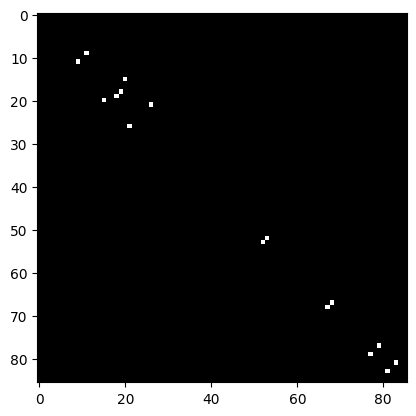

In [107]:
plt.imshow(delta[:86, :86] != 0, cmap="gray", interpolation="nearest")

In [108]:
# center_p_idx = np.argmin((points**2).sum(-1))

# b *= 0
# b = b.reshape(-1, 3)

# c_triangles = vertices_to_triangles[center_p_idx]
# b[c_triangles, np.where(triangles[c_triangles] == center_p_idx)[-1]] = -1
# b = b.reshape(-1)

In [109]:
coefs = np.linalg.solve(stiffness_matrix, b).reshape(-1, 3)

In [110]:
import plotly

In [111]:
param = np.linspace(0, 1, 10)
gridx, gridy = np.meshgrid(param, param, indexing="ij")

mask = (gridy <= 1 - gridx)

gridx = gridx[mask]
gridy = gridy[mask]

In [112]:
mapping_function_lambdified = dill.load(
    open("../../calculations/lagrange_linear_mapping_x", "rb")
)
interpolation_function_lambdified = dill.load(
    open("../../calculations/lagrange_linear_interpolation_x", "rb")
)

In [113]:
global_x, global_y, global_z = [], [], []

for t_idx, element in enumerate(triangles):
    
    x0, x1, x2 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y0, y1, y2 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    physical_x, physical_y = mapping_function_lambdified(gridx, gridy, x0, y0, x1, y1, x2, y2).squeeze()
    
    physical_z = interpolation_function_lambdified(
                                        gridx, gridy,
                                        coefs[t_idx, 0], 
                                        coefs[t_idx, 1], 
                                        coefs[t_idx, 2],
                                        ).squeeze()
    
    global_x.append(physical_x)
    global_y.append(physical_y)
    global_z.append(physical_z)
    
global_x = np.concatenate(global_x)
global_y = np.concatenate(global_y)
global_z = np.concatenate(global_z)

In [114]:
plot_data = [
    plotly.graph_objects.Mesh3d(
                                x=gx, 
                                y=gy,
                                z=gz, 
                                )
        for gx, gy, gz in zip(
                                global_x.reshape(-1, gridx.shape[0]), 
                                global_y.reshape(-1, gridx.shape[0]), 
                                global_z.reshape(-1, gridx.shape[0])
                              )
    ]
fig = plotly.graph_objects.Figure(data=plot_data)
fig.update_layout()